# Figures for Comparing Different Time Frames to Predict PTB

In [1]:
import os, sys
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import glob 
import pickle 
from scipy.cluster.hierarchy import linkage,leaves_list
from scipy.interpolate import interp1d
from cycler import cycler
from collections import OrderedDict 

from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
from IPython.core.display import display, HTML    
display(HTML("<style>.container {width:98% !important; }</style>"))
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) 

DATE = datetime.now().strftime('%Y-%m-%d')

In [2]:
sys.path.append('/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification')
from hyperparam_tune import validate_best_model

In [3]:
%load_ext rpy2.ipython

In [4]:
ROOT_DATA_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019-02-02_manuscript_time_to_delivery_icd_cpt/without_age_race_count" 
OUTPUT_DIR = "/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/scripts/rand_forest_ptb_classification/manuscript/time_to_delivery"

# Functions

In [5]:
def get_test_performance(input_file, model_file):
    
    
    input_data = pd.read_csv(input_file, sep="\t")
    print("done loading {}".format(os.path.basename(input_file)))
    
    held_out_df = input_data.loc[input_data['partition']=='held_out'].copy()
    train_df = input_data.loc[input_data['partition']=='grid_cv'].copy()
    held_out_df.set_index('GRID',inplace=True)
    train_df.set_index('GRID',inplace=True)
    
    X_test = held_out_df.iloc[:,:-2]
    y_test = held_out_df.label.apply(lambda x: 1 if x == 'preterm' else 0).values

    
    xgb_model = pickle.load(open(model_file, "rb"))
    
    return X_test, y_test, xgb_model 

In [6]:
def plot_roc(store_fpr, store_tpr, aucs, plt_prefix='', roc_fig_file=None):
    '''
    plot auroc curve(s) with mean and std; save if a roc_fig_file is provided

        INPUTS:
            * store_fpr, store_tpr, aucs: a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * roc_fig_file: full path to save file
            * savefig: boolean to save or not save figure

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating roc plot.....")

    interp_fpr = np.linspace(0, 1, 100)
    store_tpr_interp = []

    ax = plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r', label='Chance', alpha=.8)

    # plot each cv iteration
    for cv_iter, fpr_tpr_auc in enumerate(zip(store_fpr, store_tpr, aucs)):
        # set_trace()
        fpr, tpr, auc = fpr_tpr_auc
        plt.plot(fpr, tpr, lw=4, alpha=0.9, label="#{}(AUC={:.3f})".format(cv_iter, auc))

        lin_fx = interp1d(fpr, tpr, kind='linear')
        interp_tpr = lin_fx(interp_fpr)

        # store_tpr_interp.append(np.interp(mean_fpr, fpr, tpr))
        # store_tpr_interp[-1][0] = 0.0
        store_tpr_interp.append(interp_tpr)

    # plot mean and std only if more than one curve present
    if len(store_fpr) != 1:
        # plot mean, sd, and shade in between
        mean_tpr = np.mean(store_tpr_interp, axis=0)
        # mean_tpr[-1] = 1.0
        mean_auc = metrics.auc(interp_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(interp_fpr, mean_tpr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_auc, std_auc),
                 lw=2, alpha=.8)

        std_tpr = np.std(store_tpr_interp, axis=0)
        tprs_upper = np.minimum(mean_tpr + 2*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 2*std_tpr, 0)
        plt.fill_between(interp_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if roc_fig_file:
        plt.savefig(roc_fig_file)
        print("\tDone. AUROC curve saved to:\n\t{}".format(roc_fig_file))

    return ax

In [7]:
def plot_pr(precisions, recalls, avg_prs, plt_prefix, pr_fig_file=None, pos_prop=None):
    ''' plot PR curve(s) with mean and std; save if pr_fig_file is provided

        INPUTS:
            * precisions, recalls, avg_prs: must be a list where each element represents data for one curve
            * plt_prefix: label to add to the title of plot
            * pr_fig_file: full path to save file
            * pos_prop: total true positives / total samples (i.e. proportion of positves)

        note: first three must be a list; will not plot mean and std if only one curve
    '''
    print("Creating PR curve plot ...")
    # mean_rc = np.linspace(0, 1, 100)
    interp_rc = np.linspace(0, 1, 100)

    store_pr_interp = []
    ax = plt.figure()

    # plot line of random chance
    if pos_prop:
        plt.plot([0, 1], [pos_prop, pos_prop], linestyle='--', lw=4,
                 color='r', label='Chance({:.3f})'.format(pos_prop), alpha=.8)

    # plot each cv_iter
    for cv_iter, pr_rc_avg in enumerate(zip(precisions, recalls, avg_prs)):

        pr_array, rc_array, pr_avg = pr_rc_avg
        # plt.plot(rc_array, pr_array, lw=1, color='k', alpha=0.4)
        plt.step(rc_array, pr_array, lw=4, alpha=0.8, where='post', label="#{}(AvgPR={:.3f})".format(cv_iter, pr_avg))

        # interpolate recall to have the same length array for taking mean
        lin_fx = interp1d(rc_array, pr_array, kind='linear')
        interp_pr = lin_fx(interp_rc)
        store_pr_interp.append(interp_pr)

    # set_trace()

    # plot mean and std only if more than one curve present
    if len(precisions) != 1:
        # mean and std
        mean_pr = np.mean(store_pr_interp, axis=0)
        mean_avg_pr = np.mean(avg_prs)
        std_avg_pr = np.std(avg_prs)

        # std of each pr-curve
        std_pr = np.std(store_pr_interp, axis=0)
        pr_upper = np.minimum(mean_pr + 2*std_pr, 1)
        pr_lower = np.maximum(mean_pr - 2*std_pr, 0)
        plt.fill_between(interp_rc, pr_lower, pr_upper, color='grey', alpha=.2,
                         label="+/- 2 S.D.")

        plt.plot(interp_rc, mean_pr, color='b',
                 label="Mean(AUC={:.2f}+/-{:.2f})".format(mean_avg_pr, std_avg_pr), lw=2, alpha=0.8)

    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve for {}:\nPrediting PTB vs. non-PTB'.format(plt_prefix))
    plt.legend(loc="lower right")

    if pr_fig_file:
        plt.savefig(pr_fig_file)
        print("\tPR curve saved to:\n\t{}".format(pr_fig_file))

    return ax

# Raw Counts ICD & CPT 

## Load Data 

In [8]:
# load all up_to_ file names
up_to_dataset_dict = OrderedDict()
for num_days in ['0','10','90', '273','365']: 
            
    input_file = glob.glob(ROOT_DATA_DIR+'/up_to_*_days/input_data_up_to_{}_days*'.format(num_days))[0]
    model_file = glob.glob(ROOT_DATA_DIR+'/up_to_*_days/best_xgb_model_up_to_{}_days*.pickle'.format(num_days))[0]

    up_to_dataset_dict['{}_days'.format(num_days)] =  {'input_file': input_file, 'model_file': model_file}


In [9]:
# load all up_to_  file names
within_dataset_dict = OrderedDict()
for num_days in ['0','10','90','273','365']: 
            
    input_file = glob.glob(ROOT_DATA_DIR+'/within_*_days/input_data_within_{}_days*'.format(num_days))[0]
    model_file = glob.glob(ROOT_DATA_DIR+'/within_*_days/best_xgb_model_within_{}_days*'.format(num_days))[0]

    within_dataset_dict['{}_days'.format(num_days)] =  {'input_file': input_file, 'model_file': model_file}


In [10]:
new_up_to_dataset_dict = OrderedDict()
new_within_dataset_dict = OrderedDict()

In [11]:
for num_days in ['0','10','90', '273','365']: 
            
    new_up_to_dataset_dict['{}_days'.format(num_days)] = up_to_dataset_dict['{}_days'.format(num_days)]
    new_within_dataset_dict['{}_days'.format(num_days)] = within_dataset_dict['{}_days'.format(num_days)]



In [12]:
UPTO_STORED_DATA_FILE = os.path.join(OUTPUT_DIR,'up_to_datasets_dict.pickle')
WITHIN_STORED_DATA_FILE = os.path.join(OUTPUT_DIR,'within_datasets_dict.pickle')

In [13]:
# load if the data already exists... 
# UP TO 
if os.path.isfile(UPTO_STORED_DATA_FILE): 
    print("loading pickled file...")
    metrics_file = open(UPTO_STORED_DATA_FILE, 'rb')
    up_to_dataset_dict = pickle.load(metrics_file)
else: 
    print("creating data...")
    store_results = {}
    for label, inner_dict in up_to_dataset_dict.items(): 

        print(label)
        X_test, y_test, xgb_model  = get_test_performance(inner_dict['input_file'], inner_dict['model_file'])
        metrics_results, metrics_df, model_params = validate_best_model(xgb_model, X_test, y_test)

        up_to_dataset_dict[label]['metrics_df'] = metrics_df
        up_to_dataset_dict[label]['metrics_results'] = metrics_results
        up_to_dataset_dict[label]['y_test'] = y_test
        up_to_dataset_dict[label]['X_test'] = X_test

loading pickled file...


In [14]:
# load if the data already exists... 
#WITHIN  
if os.path.isfile(WITHIN_STORED_DATA_FILE): 
    print("loading pickled file...")
    metrics_file = open(WITHIN_STORED_DATA_FILE, 'rb')
    within_dataset_dict = pickle.load(metrics_file)
else: 
    print("creating data...")
    store_results = {}
    for label, inner_dict in within_dataset_dict.items(): 

        print(label)
        X_test, y_test, xgb_model  = get_test_performance(inner_dict['input_file'], inner_dict['model_file'])
        metrics_results, metrics_df, model_params = validate_best_model(xgb_model, X_test, y_test)

        within_dataset_dict[label]['metrics_df'] = metrics_df
        within_dataset_dict[label]['metrics_results'] = metrics_results
        within_dataset_dict[label]['y_test'] = y_test
        within_dataset_dict[label]['X_test'] = X_test

loading pickled file...


In [15]:
#  save stored dictionary
if  os.path.isfile(WITHIN_STORED_DATA_FILE): 
    pickle.dump(within_dataset_dict, open(WITHIN_STORED_DATA_FILE, 'wb'))    
    print("pickled model.")

if  os.path.isfile(UPTO_STORED_DATA_FILE): 
    pickle.dump(up_to_dataset_dict, open(UPTO_STORED_DATA_FILE, 'wb'))    
    print("pickled model.")    

pickled model.
pickled model.


# Create ROCs

In [16]:
%matplotlib inline

In [17]:
within_dataset_dict.keys()
up_to_dataset_dict.keys()

odict_keys(['0_days', '10_days', '90_days', '273_days', '365_days'])

odict_keys(['0_days', '10_days', '90_days', '273_days', '365_days'])

In [18]:
# new lables 
mod_names_up_to = dict(zip(up_to_dataset_dict.keys(), ['up_to_{}_before_delivery'.format(x) for x in up_to_dataset_dict.keys()]))
mod_names_within = dict(zip(within_dataset_dict.keys(), ['{}_before_delivery'.format(x) for x in within_dataset_dict.keys()]))

In [19]:
# SET UP FIGURE PARAMTERS ....
sns.set( style='whitegrid',  font_scale=1.5, rc={'figure.figsize':(8,8)} )
sns.set_style( {'axes.grid': True, 'axes.edgecolor': 'k', 'font.sans-serif': ['Arial'], 'grid.color': '#e1e1e1'})
plt.rc('axes', prop_cycle=(cycler('color', sns.color_palette("cubehelix", 5))))
fsize=20
leg_fsize=14
hex_codes = [ '#%02x%02x%02x' % tuple((np.array(x)*255).astype(int)) for x in sns.color_palette("cubehelix", 5)]

# temp dummy model

In [52]:
tfile="/dors/capra_lab/users/abraha1/projects/PTB_phenotyping/results/ptb_predict_machine_learning/2019-02-02_manuscript_time_to_delivery_icd_cpt/without_age_race_count/up_to_0_days/input_data_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.tsv"


In [53]:
tdf = pd.read_csv(tfile, sep="\t")

In [54]:
tdf.head()

,GRID,00.17,00.18,00.22,00.31,00.33,00.39,00.40,00.41,00.45,...,V91.09,V91.10,V91.11,V91.12,V91.19,V91.21,V91.22,Y1405,label,partition
0,R200006865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,term,grid_cv
1,R200009152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,postterm,held_out
2,R200021053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,preterm,grid_cv
3,R200021270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,term,grid_cv
4,R200021729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,term,grid_cv


In [68]:
X_train = tdf.loc[tdf['partition']=='grid_cv', tdf.columns.difference(['partition','label','GIRD'])].values
y_train = tdf.loc[tdf['partition']=='grid_cv', 'label'].apply(lambda x: 1 if x == 'preterm' else 0).values
X_test = tdf.loc[tdf['partition']=='held_out', tdf.columns.difference(['partition','label','GIRD'])].values
y_test = tdf.loc[tdf['partition']=='held_out', 'label'].apply(lambda x: 1 if x == 'preterm' else 0).values

In [70]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy="stratified")
dummy_classifier.fit( X_train,y_train )

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [73]:
y_rpred = dummy_classifier.predict(X_test)
y_test

array([0, 0, 0, ..., 0, 1, 0])

In [65]:
from sklearn import metrics 

In [74]:
metrics.precision_score(y_test, y_rpred)

0.2031523642732049

## AUC ROC 

### Including x days before delivery

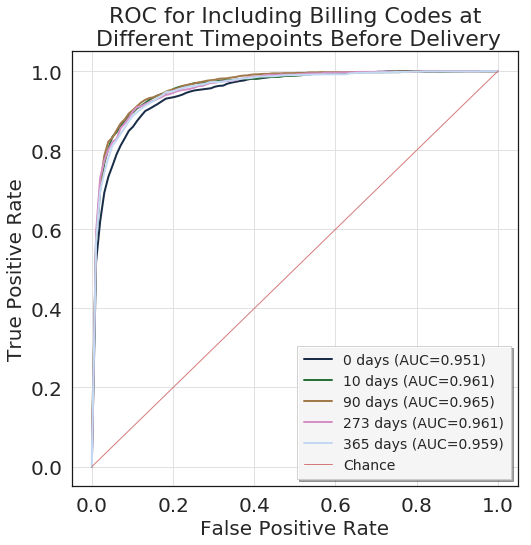

In [29]:
# BEFORE DELIVERY
fig  = plt.plot()
interp_fpr = np.linspace(0, 1, 100)
for index, label_dict in enumerate(within_dataset_dict.items()): 
    label, inner_dict = label_dict
    
    # unpack data 
    metrics_results = inner_dict['metrics_results']
    fpr = metrics_results['fpr']
    tpr = metrics_results['tpr']
    auc = metrics_results['roc_auc']
    
    # calc 
    lin_fx = interp1d(fpr, tpr, kind='linear', assume_sorted=True)
    interp_tpr = lin_fx(interp_fpr)
    
    # force a 0,0 start 
    interp_fpr = np.hstack((np.array([0]), interp_fpr))
    interp_tpr = np.hstack((np.array([0]), interp_tpr))
    
    _ = plt.plot(interp_fpr, interp_tpr, lw=2, alpha=1, linestyle='-',
             label="{}(AUC={:.3f})".format(mod_names_within[label].replace("_"," ").replace('before delivery',''), auc))
    
_ = plt.plot([0, 1], [0, 1], linestyle='-', lw=1, color='#CD5C5C', label='Chance', alpha=.8)    
_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([-0.05, 1.05])
_ = plt.xlabel('False Positive Rate', fontsize=fsize)
_ = plt.ylabel('True Positive Rate', fontsize=fsize)
_ = plt.title('ROC for Including Billing Codes at\n Different Timepoints Before Delivery', fontsize=fsize+2)
_ = plt.legend(loc="lower right", fontsize=leg_fsize, frameon=True, fancybox=False, framealpha=.9, shadow=True,borderpad=0.5)
_ = plt.tick_params(axis='both', which='major', labelsize=fsize)

# # save 
# roc_fig_file = os.path.join(OUTPUT_DIR, '{}-roc_auc_before_delivery_series.pdf'.format(DATE))
# plt.savefig(roc_fig_file)

### Excluding billing codes before delivery

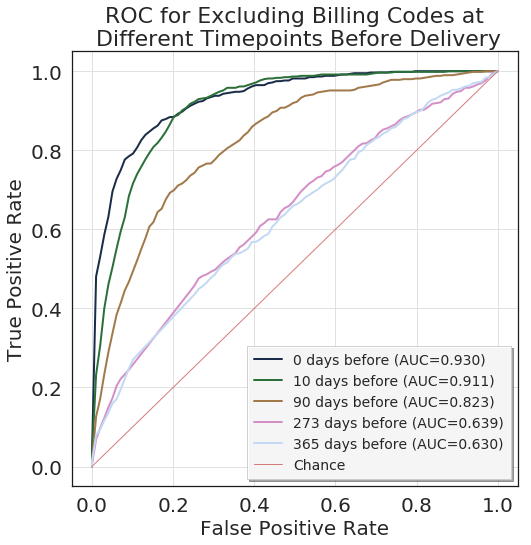

In [28]:
# UP TO DAYS  DELIVERY
fig  = plt.plot()
interp_fpr = np.linspace(0, 1, 100)
for index, label_dict in enumerate(up_to_dataset_dict.items()): 
    label, inner_dict = label_dict
    
    # unpack data 
    metrics_results = inner_dict['metrics_results']
    fpr = metrics_results['fpr']
    tpr = metrics_results['tpr']
    auc = metrics_results['roc_auc']
    
    # calc 
    lin_fx = interp1d(fpr, tpr, kind='linear', assume_sorted=True)
    interp_tpr = lin_fx(interp_fpr)
    
    # force a 0,0 start 
    interp_fpr = np.hstack((np.array([0]), interp_fpr))
    interp_tpr = np.hstack((np.array([0]), interp_tpr))
    
    _ = plt.plot(interp_fpr, interp_tpr, lw=2, alpha=1, linestyle='-',
             label="{}(AUC={:.3f})".format(mod_names_up_to[label].replace("_"," ").replace('up to ','').replace('delivery',''), auc))
    
_ = plt.plot([0, 1], [0, 1], linestyle='-', lw=1, color='#CD5C5C', label='Chance', alpha=.8)    
_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([-0.05, 1.05])
_ = plt.xlabel('False Positive Rate', fontsize=fsize)
_ = plt.ylabel('True Positive Rate', fontsize=fsize)
_ = plt.title('ROC for Excluding Billing Codes at\n Different Timepoints Before Delivery', fontsize=fsize+2)
_ = plt.legend(loc="lower right", fontsize=leg_fsize, frameon=True, fancybox=False, framealpha=.9, shadow=True,borderpad=0.5)
_ = plt.tick_params(axis='both', which='major', labelsize=fsize)

# save 
roc_fig_file = os.path.join(OUTPUT_DIR, '{}-roc_auc_up_to_x_days_before_delivery_series.pdf'.format(DATE))
plt.savefig(roc_fig_file)

## PR AUC 

### Including x days before delivery

In [3]:
# BEFORE DELIVERY
fig  = plt.plot()
interp_rc = np.linspace(0, 1, 100)
for index, label_dict in enumerate(within_dataset_dict.items()): 
    label, inner_dict = label_dict
    
    # get data 
    metrics_results = inner_dict['metrics_results']
    pr = metrics_results['pr_curve']
    rc = metrics_results['rc_curve']
    pr_auc = metrics_results['avg_prec']
    pos_prop=np.sum(inner_dict['y_test'])/len(inner_dict['y_test'])
    
    # calc 
    lin_fx = interp1d(rc, pr, kind='linear')
    interp_pr = lin_fx(interp_rc)
    
    # force a 1,pos_prop end
    interp_rc = np.hstack((interp_rc, np.array([1])))
    interp_pr = np.hstack((interp_pr, np.array([pos_prop])))
    
    _ = plt.plot(interp_rc, interp_pr, lw=2, alpha=1, linestyle='-',
             label="{}(AUC={:.3f})".format(mod_names_within[label].replace("_"," ").replace('before delivery',''), pr_auc))
    
_ = plt.plot([0, 1], [pos_prop, pos_prop], linestyle='-', lw=1,color='#CD5C5C', label='Chance({:.3f})'.format(pos_prop), alpha=.8) 
_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([-0.05, 1.05])
_ = plt.xlabel('Recall', fontsize=fsize)
_ = plt.ylabel('Precision', fontsize=fsize)
_ = plt.title('Precision-Recall for Including Billing Codes at\n Different Timepoints Before Delivery', fontsize=fsize+2)
_ = plt.legend(loc="lower right", fontsize=leg_fsize, frameon=True, fancybox=False, framealpha=.9, shadow=True,borderpad=0.5)
_ = plt.tick_params(axis='both', which='major', labelsize=fsize)

# # save 
pr_fig_file = os.path.join(OUTPUT_DIR, '{}-pr_auc-before_delivery_series.pdf'.format(DATE))
plt.savefig(pr_fig_file)

NameError: name 'plt' is not defined

### Excluding x days before delivery

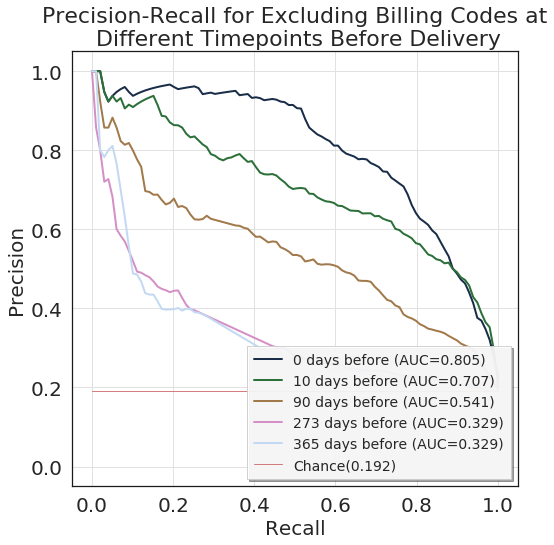

In [31]:
# UP TO X DAYS BEFORE DELIVERY
fig  = plt.plot()
interp_rc = np.linspace(0, 1, 100)
for index, label_dict in enumerate(up_to_dataset_dict.items()): 
    label, inner_dict = label_dict
    
    # get data 
    metrics_results = inner_dict['metrics_results']
    pr = metrics_results['pr_curve']
    rc = metrics_results['rc_curve']
    pr_auc = metrics_results['avg_prec']
    pos_prop=np.sum(inner_dict['y_test'])/len(inner_dict['y_test'])
    
    # calc 
    lin_fx = interp1d(rc, pr, kind='linear')
    interp_pr = lin_fx(interp_rc)
    
    # force a 1,pos_prop end
    interp_rc = np.hstack((interp_rc, np.array([1])))
    interp_pr = np.hstack((interp_pr, np.array([pos_prop])))
    
    _ = plt.plot(interp_rc, interp_pr, lw=2, alpha=1, linestyle='-',
             label="{}(AUC={:.3f})".format(mod_names_up_to[label].replace("_"," ").replace('up to ','').replace('delivery',''), pr_auc))
    
_ = plt.plot([0, 1], [pos_prop, pos_prop], linestyle='-', lw=1,color='#CD5C5C', label='Chance({:.3f})'.format(pos_prop), alpha=.8) 
_ = plt.xlim([-0.05, 1.05])
_ = plt.ylim([-0.05, 1.05])
_ = plt.xlabel('Recall', fontsize=fsize)
_ = plt.ylabel('Precision', fontsize=fsize)
_ = plt.title('Precision-Recall for Excluding Billing Codes at\n Different Timepoints Before Delivery', fontsize=fsize+2)
_ = plt.legend(loc="lower right", fontsize=leg_fsize, frameon=True, fancybox=False, framealpha=.9, shadow=True,borderpad=0.5)
_ = plt.tick_params(axis='both', which='major', labelsize=fsize)

# save 
# pr_fig_file = os.path.join(OUTPUT_DIR, '{}-pr_auc_up_to_x_days_before_delivery_series.pdf'.format(DATE))
# plt.savefig(pr_fig_file)

## F1, PR, and Recall 

In [32]:
# concat metrics_df 
up_to_all_metrics_df = pd.DataFrame()
within_all_metrics_df = pd.DataFrame()

for label, inner_dict in up_to_dataset_dict.items(): 
    
    print("up to {}".format(label))
    metrics_df = inner_dict['metrics_df']

    metrics_df['dataset'] = label
    up_to_all_metrics_df = up_to_all_metrics_df.append(metrics_df)
    
for label, inner_dict in within_dataset_dict.items(): 
    
    print("within {}".format(label))
    metrics_df = inner_dict['metrics_df']
    metrics_df['dataset'] = label
    within_all_metrics_df = within_all_metrics_df.append(metrics_df)

up to 0_days
up to 10_days
up to 90_days
up to 273_days
up to 365_days
within 0_days
within 10_days
within 90_days
within 273_days
within 365_days


In [33]:
# melt dataframe
within_melted_metrics_df = pd.melt(within_all_metrics_df, id_vars=['dataset'], value_vars=['precision','recall','f1'] )
within_melted_metrics_df.variable = within_melted_metrics_df.variable.apply(lambda x: x.upper())
within_melted_metrics_df.head(6)
within_melted_metrics_df.dataset.unique()

,dataset,variable,value
0,0_days,PRECISION,0.753133
1,10_days,PRECISION,0.778894
2,90_days,PRECISION,0.802915
3,273_days,PRECISION,0.791618
4,365_days,PRECISION,0.833012
5,0_days,RECALL,0.812162


array(['0_days', '10_days', '90_days', '273_days', '365_days'],
      dtype=object)

In [34]:
# melt dataframe
upto_melted_metrics_df = pd.melt(up_to_all_metrics_df, id_vars=['dataset'], value_vars=['precision','recall','f1'] )
upto_melted_metrics_df.variable = within_melted_metrics_df.variable.apply(lambda x: x.upper())
upto_melted_metrics_df.head(6)
upto_melted_metrics_df.dataset.unique()

,dataset,variable,value
0,0_days,PRECISION,0.660563
1,10_days,PRECISION,0.555556
2,90_days,PRECISION,0.427435
3,273_days,PRECISION,0.258595
4,365_days,PRECISION,0.247312
5,0_days,RECALL,0.788235


array(['0_days', '10_days', '90_days', '273_days', '365_days'],
      dtype=object)

### bar plot

#### including x days before delivery

/dors/capra_lab/users/abraha1/conda/envs/py36_r/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


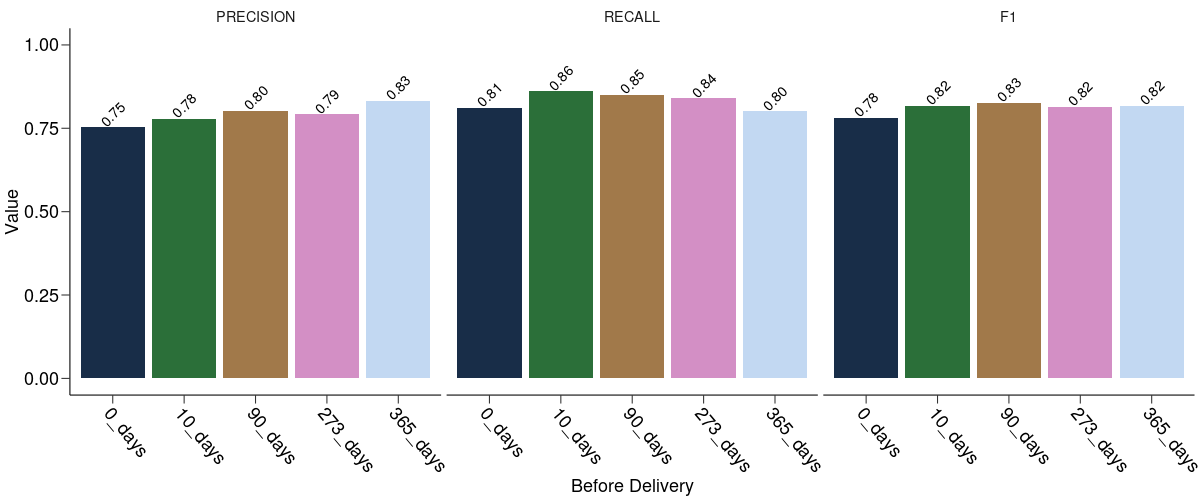

In [35]:
%%R -i within_melted_metrics_df -i DATE -i OUTPUT_DIR -h 500 -w 1200 -i hex_codes
### PLOT ALL DATA POINTS 
melted_metrics_df = within_melted_metrics_df
library(ggplot2)

melted_metrics_df$dataset <-factor(melted_metrics_df$dataset, levels = c('0_days', '10_days', '90_days', '273_days', '365_days'))
melted_metrics_df$variable <-factor(melted_metrics_df$variable,levels = c("PRECISION",'RECALL','F1'))

mplt = ggplot(data = melted_metrics_df, aes(x=dataset, y=value, fill=dataset, label=sprintf("%0.2f", round(value, digits = 2)))) 
mplt = mplt + geom_bar(stat="identity",  position="dodge")
mplt = mplt + geom_text(aes(y = value + 0.04), position =position_dodge(0.9), size = 5, angle=45) 
mplt = mplt + facet_grid(~variable)

# might have to fix this manual scale 
mplt = mplt + scale_fill_manual(values=c('#182d48', '#2b6f39', '#a1794a', '#d38fc5', '#c2d8f2'))
mplt = mplt + xlab("Before Delivery")
mplt = mplt + ylab("Value")
mplt = mplt + ylim(c(0,1))
mplt + theme_classic() + theme(
    text = element_text(size=18, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.text.x = element_text(angle=310, hjust=0),
    axis.ticks.length=unit(.3,"cm"),
    legend.position="none",
    strip.background = element_rect(colour="white", fill="white"))

# fig_file =  sprintf('%s-f1_rc_pr_before_delivery_series.pdf',DATE)
# ggsave(fig_file, plot=last_plot(), device=cairo_pdf, path=OUTPUT_DIR)

#### excludign x days before delviery

In [36]:
upto_melted_metrics_df.head()

,dataset,variable,value
0,0_days,PRECISION,0.660563
1,10_days,PRECISION,0.555556
2,90_days,PRECISION,0.427435
3,273_days,PRECISION,0.258595
4,365_days,PRECISION,0.247312


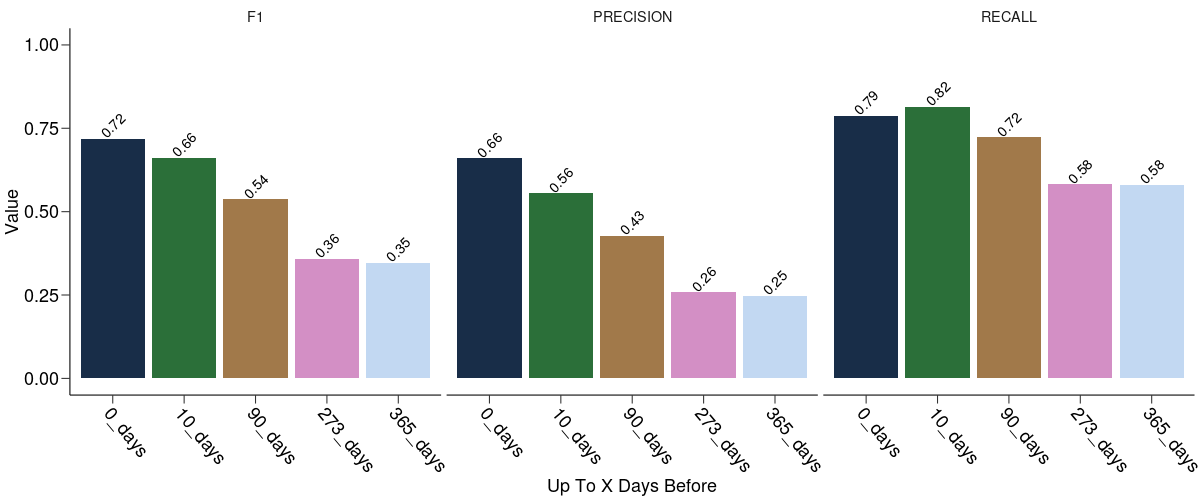

In [38]:
%%R -i upto_melted_metrics_df -i DATE -i OUTPUT_DIR -h 500 -w 1200 -i hex_codes
### PLOT ALL DATA POINTS 
melted_metrics_df = upto_melted_metrics_df
library(ggplot2)

melted_metrics_df$dataset <-factor(melted_metrics_df$dataset, levels = c('0_days', '10_days', '90_days', '273_days', '365_days'))
melted_metrics_df$variable <-factor(melted_metrics_df$variable,levels = c("F1", "PRECISION",'RECALL'))

mplt = ggplot(data = melted_metrics_df, aes(x=dataset, y=value, fill=dataset, label=sprintf("%0.2f", round(value, digits = 2)))) 
mplt = mplt + geom_bar(stat="identity",  position="dodge")
mplt = mplt + geom_text(aes(y = value + 0.04), position =position_dodge(0.9), size = 5, angle=45) 
mplt = mplt + facet_grid(~variable)


# might have to fix this manual scale 
mplt = mplt + scale_fill_manual(values=c('#182d48', '#2b6f39', '#a1794a', '#d38fc5', '#c2d8f2'))
mplt = mplt + xlab("Up To X Days Before")
mplt = mplt + ylab("Value")
mplt = mplt + ylim(c(0,1))

mplt + theme_classic() + theme(
    text = element_text(size=18, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.text.x = element_text(angle=310, hjust=0),
    axis.ticks.length=unit(.3,"cm"),
    legend.position="none",
    strip.background = element_rect(colour="white", fill="white"))

# fig_file =  sprintf('%s-f1_rc_pr_up_to_x_days_before_delivery_series.pdf',DATE)
# ggsave(fig_file, plot=last_plot(), device=cairo_pdf, path=OUTPUT_DIR)

## Brier Score Bar Plot

In [39]:
# melt dataframe
# UP TO 
up_to_melt_brier_df = pd.melt(up_to_all_metrics_df, id_vars=['dataset'], value_vars=['brier_score'] )
up_to_melt_brier_df.variable = up_to_melt_brier_df.variable.str.upper()
up_to_melt_brier_df.head(10)

,dataset,variable,value
0,0_days,BRIER_SCORE,0.083570
1,10_days,BRIER_SCORE,0.106189
2,90_days,BRIER_SCORE,0.162177
3,273_days,BRIER_SCORE,0.249453
4,365_days,BRIER_SCORE,0.247424


In [40]:
# melt dataframe
# WITHIN
within_melt_brier_df = pd.melt(within_all_metrics_df, id_vars=['dataset'], value_vars=['brier_score'] )
within_melt_brier_df.variable = within_melt_brier_df.variable.str.upper()
within_melt_brier_df.head(10)

,dataset,variable,value
0,0_days,BRIER_SCORE,0.069930
1,10_days,BRIER_SCORE,0.062720
2,90_days,BRIER_SCORE,0.058681
3,273_days,BRIER_SCORE,0.062061
4,365_days,BRIER_SCORE,0.064772


#### including x days before delivery

In [ ]:
%%R  -i within_melt_brier_df -i OUTPUT_DIR -i DATE

melt_brier_df = within_melt_brier_df
# order labels 
# melt_brier_df$model <-factor(melt_brier_df$model, levels = c("baseline", "all"))

barplt = ggplot(data = melt_brier_df,
                aes(x=dataset, y=value, fill=dataset,
                label=sprintf("%0.3f", round(value, digits = 3)))) 

barplt = barplt + geom_bar(stat="identity")
barplt =barplt + geom_text(aes(y = value + 0.004), size = 5, angle = 0, position = position_dodge(0.9))


barplt = barplt + scale_fill_manual(values= c('#182d48', '#2b6f39', '#a1794a', '#d38fc5', '#c2d8f2'))
barplt = barplt + ylab("Brier Score")
barplt = barplt + xlab("Before Delivery")

barplt = barplt + theme_classic() + theme(
    text = element_text(size=13, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.ticks.length=unit(.3,"cm"),
    axis.text.x = element_text(angle=315, hjust=0),
    strip.background = element_rect(colour="white", fill="white"),
    strip.text.x = element_text(size=12, family="arial", color="darkred", face="plain"),
    axis.title.y = element_text(size=18, family="arial", color="black"),
    legend.position="none")

barplt
# pr_fig_file =  sprintf('%s-brier_before_delivery.pdf',DATE)
# ggsave(pr_fig_file, plot=last_plot(), device=cairo_pdf, path=OUTPUT_DIR)

### Excluding x days before delivery

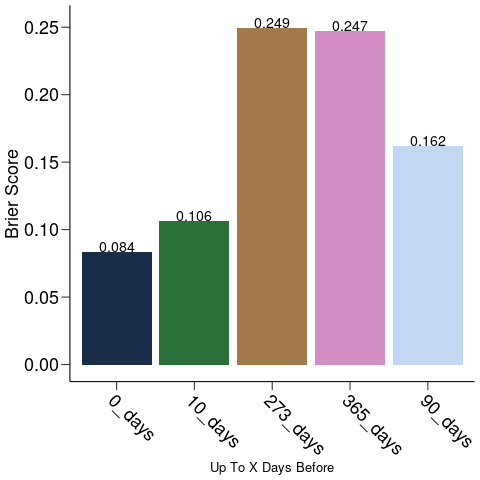

In [41]:
%%R  -i up_to_melt_brier_df -i OUTPUT_DIR -i DATE

melt_brier_df = up_to_melt_brier_df
# order labels 
# melt_brier_df$model <-factor(melt_brier_df$model, levels = c("baseline", "all"))

barplt = ggplot(data = melt_brier_df,
                aes(x=dataset, y=value, fill=dataset,
                label=sprintf("%0.3f", round(value, digits = 3)))) 

barplt = barplt + geom_bar(stat="identity")
barplt =barplt + geom_text(aes(y = value + 0.004), size = 5, angle = 0, position = position_dodge(0.9))


barplt = barplt + scale_fill_manual(values= c('#182d48', '#2b6f39', '#a1794a', '#d38fc5', '#c2d8f2'))
barplt = barplt + ylab("Brier Score")
barplt = barplt + xlab("Up To X Days Before")


barplt = barplt + theme_classic() + theme(
    text = element_text(size=13, family="arial", color="black"),
    axis.text = element_text(size=18, family="arial", color="black"),
    axis.ticks.length=unit(.3,"cm"),
    axis.text.x = element_text(angle=315, hjust=0),
    strip.background = element_rect(colour="white", fill="white"),
    strip.text.x = element_text(size=12, family="arial", color="darkred", face="plain"),
    axis.title.y = element_text(size=18, family="arial", color="black"),
    legend.position="none")

barplt

# pr_fig_file =  sprintf('%s-brier-up_to_x_days_before.pdf',DATE)
# ggsave(pr_fig_file, plot=last_plot(), device=cairo_pdf, path=OUTPUT_DIR)

## Feature Importance 

In [201]:
!ls $ROOT_DATA_DIR/up_to_0_days

best_hyperparam_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.tsv
best_xgb_model_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.pickle
feature_importance_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.tsv
held_out_metrics_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.tsv
hyperopt_trials_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.tsv
input_data_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.tsv
plot_feat_importance_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.png
pr_auc_optimized_ptb_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.png
roc_auc_optimized_ptb_up_to_0_days_before_delivery_icd9_cpt_count-2019-02-16.png
